In [1]:
import pandas as pd
from plot_params import *
import pandas as pd
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import warnings
from tqdm import trange, tqdm_notebook
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Read output from score_fa_nomask.py 
- See: score_with_model-30bp.smk
- input: fasta file of sequences
- output: *.score.csv where:
  - score contains the dlogodds prediction (liklihood of RBP binding this sequence?) for each sequence, in csv format
  - join and aggregate prediction scores with hotspot/motif sequences
  - score.csv format:
```
,dlogodds_pred,ID
0,-0.045130283,0
1,0.03233305,1
2,-0.03293328,2
```

In [2]:
syt4_data = pd.read_csv(outdir / 'syt4_hotspots_30bp.csv.gz', index_col=0)  # from 0_join_data-human-30bp.ipynb
bg_data = pd.read_csv(outdir / 'Human_annotated_30bp.csv.gz', index_col=0)

syt4_basedir = Path('/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/charlene_work/eclip_model_scores_human_30bp_syt4/output/')  # See analysis_snake
bg_basedir = Path('/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/charlene_work/eclip_model_scores_human_30bp/output/')  # See analysis_snake

all_data = {}

for data, basedir, label in zip([syt4_data, bg_data], [syt4_basedir, bg_basedir], ['syt4', 'bg']):
    
    all_scores = basedir.glob('*.score.csv')
    
    for f in all_scores:
        name = f.name.split('.')[0]
        df = pd.read_csv(f,
                        index_col = 0)
        df.set_index('ID', inplace = True)
        df.rename({'dlogodds_pred': name}, axis = 1, inplace = True)
        data[name]=df[name]
        
    all_data[label] = data

print(f"Read in {all_data['syt4'].shape[0]} entries for syt4, {all_data['bg'].shape[0]} entries from background")

Read in 3 entries for syt4, 6969886 entries from background


## Concatenate syt4 scores and background, removing any syt4 datasets from background
- Kind of a silly way to ensure that we're only using the scores from the deleted area

In [3]:
# AARS is not a selected model according to model_performance.csv
# Will not be run again in the final version
try:
    del all_data['bg']['AARS_K562_ENCSR825SVO']
except Exception as e:
    pass
all_data['bg'] = all_data['bg'][all_data['bg']['transcript_id']!='ENST00000255224']  # redundant for 30bp tests, may be needed for 90bp

data = pd.concat([all_data['syt4'], all_data['bg']])
data.head()

,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq,DDX41_K562_5081,AQR_HepG2_ENCSR018WPY,...,GTF2F1_HepG2_ENCSR265ZIS,PSMA1_K562_4017,HNRNPM_HepG2_ENCSR267UCX,DDX5_K562_5094,EIF2B5_K562_5020,GRSF1_HepG2_ENCSR668MJX,CTCF_K562_4065,PTBP1_K562_5015,BUD13_K562_ENCSR663WES,ZNF800_K562_ENCSR586DGV
tile1,ENST00000255224,240,270,-0.488281,0.222656,CDS,CDS,TTGATGAAATCCCCACAGTGGTGGGGATCT,0.706816,1.239099,...,0.242650,1.294726,0.903786,0.595390,0.934263,1.092758,0.851475,1.042259,0.674624,1.033795
tile2,ENST00000255224,270,300,-0.683716,0.027222,CDS,CDS,TCAGTGCATTTGGCCTGGTCTTCACAGTCT,0.662713,1.247178,...,0.208296,1.258591,0.900579,0.599105,0.899902,1.088510,0.833637,1.095500,0.662636,0.959619
tile3,ENST00000255224,300,330,-0.684937,0.026001,CDS,CDS,CTCTCTTTGCATGGATCTGCTGTCAGAGAA,0.674583,1.253784,...,0.242019,1.264254,0.862138,0.641446,0.940091,1.063744,0.844027,1.105356,0.664061,1.027797
0,ENST00000000233,0,30,0.000000,0.044434,UTR5,UTR5,CTGCTGCTGCTGCGCCCCATCCCCCCGCGG,0.621414,1.272295,...,0.238074,1.265944,0.788839,0.518209,0.925792,1.056194,0.848789,1.077255,0.684150,1.044325
1,ENST00000000233,15,45,0.000000,0.044434,UTR5,UTR5,CCCATCCCCCCGCGGCCGGCCAGTTCCAGC,0.645101,1.239188,...,0.212154,1.280311,0.744100,0.567221,0.867844,1.051970,0.834800,1.078154,0.656130,1.022958


In [4]:
data['annotation']=data.apply(
    lambda row: 'UTR5' if row['start_annotation']=='UTR5' and row['end_annotation']=='UTR5' else
     'UTR3' if row['start_annotation']=='UTR3' and row['end_annotation']=='UTR3' else 'CDS', axis = 1)
data.head()

,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq,DDX41_K562_5081,AQR_HepG2_ENCSR018WPY,...,PSMA1_K562_4017,HNRNPM_HepG2_ENCSR267UCX,DDX5_K562_5094,EIF2B5_K562_5020,GRSF1_HepG2_ENCSR668MJX,CTCF_K562_4065,PTBP1_K562_5015,BUD13_K562_ENCSR663WES,ZNF800_K562_ENCSR586DGV,annotation
tile1,ENST00000255224,240,270,-0.488281,0.222656,CDS,CDS,TTGATGAAATCCCCACAGTGGTGGGGATCT,0.706816,1.239099,...,1.294726,0.903786,0.595390,0.934263,1.092758,0.851475,1.042259,0.674624,1.033795,CDS
tile2,ENST00000255224,270,300,-0.683716,0.027222,CDS,CDS,TCAGTGCATTTGGCCTGGTCTTCACAGTCT,0.662713,1.247178,...,1.258591,0.900579,0.599105,0.899902,1.088510,0.833637,1.095500,0.662636,0.959619,CDS
tile3,ENST00000255224,300,330,-0.684937,0.026001,CDS,CDS,CTCTCTTTGCATGGATCTGCTGTCAGAGAA,0.674583,1.253784,...,1.264254,0.862138,0.641446,0.940091,1.063744,0.844027,1.105356,0.664061,1.027797,CDS
0,ENST00000000233,0,30,0.000000,0.044434,UTR5,UTR5,CTGCTGCTGCTGCGCCCCATCCCCCCGCGG,0.621414,1.272295,...,1.265944,0.788839,0.518209,0.925792,1.056194,0.848789,1.077255,0.684150,1.044325,UTR5
1,ENST00000000233,15,45,0.000000,0.044434,UTR5,UTR5,CCCATCCCCCCGCGGCCGGCCAGTTCCAGC,0.645101,1.239188,...,1.280311,0.744100,0.567221,0.867844,1.051970,0.834800,1.078154,0.656130,1.022958,UTR5


<Axes: >

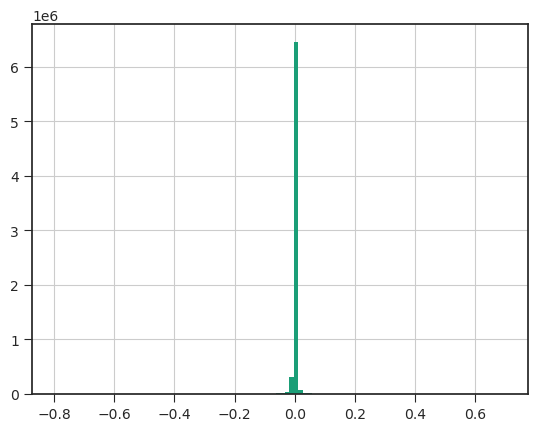

In [5]:
data['difference'].hist(bins = 100)

In [6]:
data['difference_bin'] = pd.cut(
    data['difference'], 
    bins=[-np.inf, -0.1, 0.1, np.inf],
    labels=['<-0.1', 'middle', '>0.1']
)

data = data[(data['difference_bin']=='middle') | (data['transcript_id']=='ENST00000255224')]
print(data['difference_bin'].value_counts())  # should be just 3 <-0.1 for syt4
data.head()

difference_bin
middle    6948758
<-0.1           3
>0.1            0
Name: count, dtype: int64


,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq,DDX41_K562_5081,AQR_HepG2_ENCSR018WPY,...,HNRNPM_HepG2_ENCSR267UCX,DDX5_K562_5094,EIF2B5_K562_5020,GRSF1_HepG2_ENCSR668MJX,CTCF_K562_4065,PTBP1_K562_5015,BUD13_K562_ENCSR663WES,ZNF800_K562_ENCSR586DGV,annotation,difference_bin
tile1,ENST00000255224,240,270,-0.488281,0.222656,CDS,CDS,TTGATGAAATCCCCACAGTGGTGGGGATCT,0.706816,1.239099,...,0.903786,0.595390,0.934263,1.092758,0.851475,1.042259,0.674624,1.033795,CDS,<-0.1
tile2,ENST00000255224,270,300,-0.683716,0.027222,CDS,CDS,TCAGTGCATTTGGCCTGGTCTTCACAGTCT,0.662713,1.247178,...,0.900579,0.599105,0.899902,1.088510,0.833637,1.095500,0.662636,0.959619,CDS,<-0.1
tile3,ENST00000255224,300,330,-0.684937,0.026001,CDS,CDS,CTCTCTTTGCATGGATCTGCTGTCAGAGAA,0.674583,1.253784,...,0.862138,0.641446,0.940091,1.063744,0.844027,1.105356,0.664061,1.027797,CDS,<-0.1
0,ENST00000000233,0,30,0.000000,0.044434,UTR5,UTR5,CTGCTGCTGCTGCGCCCCATCCCCCCGCGG,0.621414,1.272295,...,0.788839,0.518209,0.925792,1.056194,0.848789,1.077255,0.684150,1.044325,UTR5,middle
1,ENST00000000233,15,45,0.000000,0.044434,UTR5,UTR5,CCCATCCCCCCGCGGCCGGCCAGTTCCAGC,0.645101,1.239188,...,0.744100,0.567221,0.867844,1.051970,0.834800,1.078154,0.656130,1.022958,UTR5,middle


In [7]:
data[data['difference_bin']=='<-0.1']

,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq,DDX41_K562_5081,AQR_HepG2_ENCSR018WPY,...,HNRNPM_HepG2_ENCSR267UCX,DDX5_K562_5094,EIF2B5_K562_5020,GRSF1_HepG2_ENCSR668MJX,CTCF_K562_4065,PTBP1_K562_5015,BUD13_K562_ENCSR663WES,ZNF800_K562_ENCSR586DGV,annotation,difference_bin
tile1,ENST00000255224,240,270,-0.488281,0.222656,CDS,CDS,TTGATGAAATCCCCACAGTGGTGGGGATCT,0.706816,1.239099,...,0.903786,0.595390,0.934263,1.092758,0.851475,1.042259,0.674624,1.033795,CDS,<-0.1
tile2,ENST00000255224,270,300,-0.683716,0.027222,CDS,CDS,TCAGTGCATTTGGCCTGGTCTTCACAGTCT,0.662713,1.247178,...,0.900579,0.599105,0.899902,1.088510,0.833637,1.095500,0.662636,0.959619,CDS,<-0.1
tile3,ENST00000255224,300,330,-0.684937,0.026001,CDS,CDS,CTCTCTTTGCATGGATCTGCTGTCAGAGAA,0.674583,1.253784,...,0.862138,0.641446,0.940091,1.063744,0.844027,1.105356,0.664061,1.027797,CDS,<-0.1


## KS tests
- May not be useful as Syt4 distribution is comprised of only has three scores.
- But let's run this code anyway just in case.

In [8]:
fdr_thres = 0.2
stat_all = []
progress = trange(len(data.columns[8:-2]), leave=False, position=0)
for exp in data.columns[8:-2]:
    for cat in ['<-0.1']:
        progress.set_description(f"{exp}")
        sample = data.loc[(data['difference_bin']==cat), exp]
        bg = data.loc[(data['difference_bin']=='middle'), exp]
        ks, pv = ks_2samp(
            sample, 
            bg, 
            alternative='two-sided'
        )
        
        median_difference = sample.median() - bg.median()
        stat_all.append([ks, pv, exp, cat, median_difference])
    progress.update(1)
stat_all = pd.DataFrame(
    stat_all, 
    columns = ['KS statistics', 'pvalue', 'RBPNet_model', 'category', 'median difference']
)
stat_all.head()

ZNF800_K562_ENCSR586DGV: 100%|██████████| 172/172 [02:02<00:00,  1.41it/s]   

,KS statistics,pvalue,RBPNet_model,category,median difference
0,0.544284,0.238195,DDX41_K562_5081,<-0.1,0.015552
1,0.409192,0.569219,AQR_HepG2_ENCSR018WPY,<-0.1,-0.002777
2,0.707833,0.049880,HNRNPU_HepG2_ENCSR240MVJ,<-0.1,0.060583
3,0.379739,0.650922,PUM2_K562_ENCSR661ICQ,<-0.1,0.002065
4,0.731749,0.038606,GARS_HepG2_4108,<-0.1,-0.019825


In [9]:
stat_all['sig'],stat_all['FDR'] = fdrcorrection(stat_all['pvalue'], alpha = fdr_thres)
#stat_all['l2or'] = np.log2(stat_all['odds ratio'])
stat_all['-log10 FDR']= -np.log10(stat_all['FDR']+stat_all.loc[stat_all['pvalue']>0, 'pvalue'].min())

In [10]:
stat_all.head()

,KS statistics,pvalue,RBPNet_model,category,median difference,sig,FDR,-log10 FDR
0,0.544284,0.238195,DDX41_K562_5081,<-0.1,0.015552,False,0.499693,0.300620
1,0.409192,0.569219,AQR_HepG2_ENCSR018WPY,<-0.1,-0.002777,False,0.669382,0.173820
2,0.707833,0.049880,HNRNPU_HepG2_ENCSR240MVJ,<-0.1,0.060583,False,0.238314,0.621432
3,0.379739,0.650922,PUM2_K562_ENCSR661ICQ,<-0.1,0.002065,False,0.735646,0.132871
4,0.731749,0.038606,GARS_HepG2_4108,<-0.1,-0.019825,False,0.210178,0.675804


In [11]:
stat_30 = stat_all.loc[(stat_all['sig'])&(stat_all['category']!='middle')].sort_values(
    by = 'median difference', ascending = False
)
stat_30.to_csv(outdir / 'neural_network_enrichment_syt4_30bp_region.csv')

In [ ]:
# I also scored the full mutation sequence (90bp) without splitting it up. 
- Here I'm just comparing the values to what we get using 30bp tiles 

In [12]:
syt4_90_basedir = Path('/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/charlene_work/eclip_model_scores_human_90bp_syt4/output/')  # See analysis_snake


data = {}
all_scores = syt4_90_basedir.glob('*.score.csv')
for f in all_scores:
    name = f.name.split('.')[0]
    df = pd.read_csv(f, index_col = 0)
    df.set_index('ID', inplace = True)
    df.rename({'dlogodds_pred': name}, axis = 1, inplace = True)
    data[name]=df[name]
    
data = pd.DataFrame(data)
data = pd.concat([data, all_data['bg']])
data

,DDX41_K562_5081,AQR_HepG2_ENCSR018WPY,HNRNPU_HepG2_ENCSR240MVJ,PUM2_K562_ENCSR661ICQ,GARS_HepG2_4108,PRK2_K562_5064,U2AF1_HepG2_ENCSR328LLU,EIF3A_K562_4138,SUGP2_HepG2_ENCSR506UPY,KHSRP_HepG2_ENCSR366DGX,...,BUD13_K562_ENCSR663WES,ZNF800_K562_ENCSR586DGV,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq
syt4,0.109746,0.650559,0.132370,1.685242,1.088895,0.887880,0.475683,1.630698,0.336625,0.044584,...,0.329289,0.658532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.621414,1.272295,0.339025,1.757479,1.085721,0.865468,0.179062,1.316945,0.141085,0.315588,...,0.684150,1.044325,ENST00000000233,0.0,30.0,0.0,0.044434,UTR5,UTR5,CTGCTGCTGCTGCGCCCCATCCCCCCGCGG
1,0.645101,1.239188,0.346420,1.758417,1.097264,0.870603,0.207846,1.348391,0.139665,0.310120,...,0.656130,1.022958,ENST00000000233,15.0,45.0,0.0,0.044434,UTR5,UTR5,CCCATCCCCCCGCGGCCGGCCAGTTCCAGC
2,0.677037,1.241189,0.353343,1.758963,1.099845,0.874594,0.202116,1.332429,0.131160,0.300169,...,0.662744,1.021055,ENST00000000233,30.0,60.0,0.0,0.044434,UTR5,UTR5,CCGGCCAGTTCCAGCCCGCACCCCGCGTCG
3,0.608661,1.243805,0.310902,1.752744,1.096855,0.879965,0.222682,1.327171,0.113366,0.312626,...,0.605200,1.027494,ENST00000000233,45.0,75.0,0.0,0.044434,UTR5,UTR5,CCGCACCCCGCGTCGGTGCCCGCGCCCCTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6969881,0.662230,1.259953,0.385935,1.757852,1.122382,0.876922,0.232352,1.411477,0.166378,0.334096,...,0.653513,0.982547,ENST00000707136,2835.0,2865.0,0.0,0.018433,CDS,CDS,TGTGTCCACTCAGGGTTAAATGGATTAAGG
6969882,0.699685,1.281302,0.424250,1.769698,1.102812,0.849056,0.191402,1.366857,0.182787,0.346512,...,0.692553,1.037162,ENST00000707136,2850.0,2880.0,0.0,0.018433,CDS,CDS,TTAAATGGATTAAGGGCGGTGCAAGATGTG
6969883,0.628417,1.258001,0.316771,1.761923,1.118959,0.881802,0.319948,1.410462,0.123080,0.317733,...,0.577917,1.023199,ENST00000707136,2865.0,2895.0,0.0,0.018433,CDS,CDS,GCGGTGCAAGATGTGCTTTGTTAAACAGAT
6969884,0.668094,1.268483,0.375331,1.766921,1.117174,0.866772,0.196751,1.385627,0.171157,0.330827,...,0.650702,1.023962,ENST00000707136,2880.0,2910.0,0.0,0.018433,CDS,CDS,CTTTGTTAAACAGATGCTTGAAGGCAGCAT


In [13]:
data.loc['syt4', 'difference'] = -100  # We don't have an actual occlusion score since this is a merged motif. But since we're just binning then we just need to ensure that it is labeled as negatively impactful.
data.loc['syt4', 'transcript_id'] = 'ENST00000255224'  # syt4 transcript

data['difference_bin'] = pd.cut(
    data['difference'], 
    bins=[-np.inf, -0.1, 0.1, np.inf],
    labels=['<-0.1', 'middle', '>0.1']
)

data = data[(data['difference_bin']=='middle') | (data['transcript_id']=='ENST00000255224')]
print(data['difference_bin'].value_counts())  # should be just 3 <-0.1 for syt4
data.head()

difference_bin
middle    6948758
<-0.1           1
>0.1            0
Name: count, dtype: int64


,DDX41_K562_5081,AQR_HepG2_ENCSR018WPY,HNRNPU_HepG2_ENCSR240MVJ,PUM2_K562_ENCSR661ICQ,GARS_HepG2_4108,PRK2_K562_5064,U2AF1_HepG2_ENCSR328LLU,EIF3A_K562_4138,SUGP2_HepG2_ENCSR506UPY,KHSRP_HepG2_ENCSR366DGX,...,ZNF800_K562_ENCSR586DGV,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq,difference_bin
syt4,0.109746,0.650559,0.132370,1.685242,1.088895,0.887880,0.475683,1.630698,0.336625,0.044584,...,0.658532,ENST00000255224,NaN,NaN,-100.0,NaN,NaN,NaN,NaN,<-0.1
0,0.621414,1.272295,0.339025,1.757479,1.085721,0.865468,0.179062,1.316945,0.141085,0.315588,...,1.044325,ENST00000000233,0.0,30.0,0.0,0.044434,UTR5,UTR5,CTGCTGCTGCTGCGCCCCATCCCCCCGCGG,middle
1,0.645101,1.239188,0.346420,1.758417,1.097264,0.870603,0.207846,1.348391,0.139665,0.310120,...,1.022958,ENST00000000233,15.0,45.0,0.0,0.044434,UTR5,UTR5,CCCATCCCCCCGCGGCCGGCCAGTTCCAGC,middle
2,0.677037,1.241189,0.353343,1.758963,1.099845,0.874594,0.202116,1.332429,0.131160,0.300169,...,1.021055,ENST00000000233,30.0,60.0,0.0,0.044434,UTR5,UTR5,CCGGCCAGTTCCAGCCCGCACCCCGCGTCG,middle
3,0.608661,1.243805,0.310902,1.752744,1.096855,0.879965,0.222682,1.327171,0.113366,0.312626,...,1.027494,ENST00000000233,45.0,75.0,0.0,0.044434,UTR5,UTR5,CCGCACCCCGCGTCGGTGCCCGCGCCCCTC,middle


## Since we just have one value, I'm only recycling this code for formatting purposes.

In [16]:
data.columns[:-9]

Index(['DDX41_K562_5081', 'AQR_HepG2_ENCSR018WPY', 'HNRNPU_HepG2_ENCSR240MVJ',
       'PUM2_K562_ENCSR661ICQ', 'GARS_HepG2_4108', 'PRK2_K562_5064',
       'U2AF1_HepG2_ENCSR328LLU', 'EIF3A_K562_4138', 'SUGP2_HepG2_ENCSR506UPY',
       'KHSRP_HepG2_ENCSR366DGX',
       ...
       'GTF2F1_HepG2_ENCSR265ZIS', 'PSMA1_K562_4017',
       'HNRNPM_HepG2_ENCSR267UCX', 'DDX5_K562_5094', 'EIF2B5_K562_5020',
       'GRSF1_HepG2_ENCSR668MJX', 'CTCF_K562_4065', 'PTBP1_K562_5015',
       'BUD13_K562_ENCSR663WES', 'ZNF800_K562_ENCSR586DGV'],
      dtype='object', length=173)

In [17]:
fdr_thres = 0.2
stat_90 = []
progress = trange(len(data.columns[:-9]), leave=False, position=0)
for exp in data.columns[:-9]:
    for cat in ['<-0.1']:
        progress.set_description(f"{exp}")
        sample = data.loc[(data['difference_bin']==cat), exp]
        bg = data.loc[(data['difference_bin']=='middle'), exp]
        ks, pv = ks_2samp(
            sample, 
            bg, 
            alternative='two-sided'
        )
        
        median_difference = sample.median() - bg.median()
        stat_90.append([ks, pv, exp, cat, median_difference])
    progress.update(1)
stat_90 = pd.DataFrame(
    stat_90, 
    columns = ['KS statistics', 'pvalue', 'RBPNet_model', 'category', 'median difference']
)
stat_90.head()

AARS_K562_ENCSR825SVO:  12%|█▏        | 21/173 [00:15<01:48,  1.40it/s]    /tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
ZNF800_K562_ENCSR586DGV: 100%|██████████| 173/173 [02:01<00:00,  1.43it/s]   

,KS statistics,pvalue,RBPNet_model,category,median difference
0,1.000000,0.000000,DDX41_K562_5081,<-0.1,-0.549285
1,0.999480,0.001039,AQR_HepG2_ENCSR018WPY,<-0.1,-0.599396
2,0.990001,0.019999,HNRNPU_HepG2_ENCSR240MVJ,<-0.1,-0.230827
3,1.000000,0.000000,PUM2_K562_ENCSR661ICQ,<-0.1,-0.074281
4,0.885342,0.229316,GARS_HepG2_4108,<-0.1,-0.020398


In [18]:
stat_90.to_csv(outdir / 'neural_network_enrichment_syt4_90bp_region.csv')

In [22]:
pd.merge(stat_30, stat_90[['RBPNet_model', 'median difference']], how='inner', left_on=['RBPNet_model'], right_on=['RBPNet_model'] )[[
    'median difference_x', 'median difference_y'
]].corr()

,median difference_x,median difference_y
median difference_x,1.000000,-0.031619
median difference_y,-0.031619,1.000000


In [24]:
data.loc['syt4']

DDX41_K562_5081             0.109746
AQR_HepG2_ENCSR018WPY       0.650559
HNRNPU_HepG2_ENCSR240MVJ     0.13237
PUM2_K562_ENCSR661ICQ       1.685242
GARS_HepG2_4108             1.088895
                              ...   
synapse_probability              NaN
start_annotation                 NaN
end_annotation                   NaN
subseq                           NaN
difference_bin                 <-0.1
Name: syt4, Length: 182, dtype: object

In [32]:
data.drop('syt4')['DDX41_K562_5081'].median()

0.6590309

In [33]:
0.109746-0.6590309

-0.5492849